In [1]:
"""
Docstring for FS_biexp.ipynb

Testing how the biexponential autapse affects the FS neuron AHP. 

"""

'\nDocstring for FS_biexp.ipynb\n\nTesting how the biexponential autapse affects the FS neuron AHP. \n\n'

In [2]:
import sys
sys.path.append("..//")

from AQUA_general import AQUA
from batchAQUA_general import batchAQUA
from stimulus import *
from plotting_functions import *

#from AQUAmeetBrian import AQUAMeetBrian


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from brian2 import *
prefs.codegen.target = 'numpy'

WARNING    'C' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 20. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'a' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 0.2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'k' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    't_a1' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 1.5. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    't_a2' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 5. The internal variable will be u

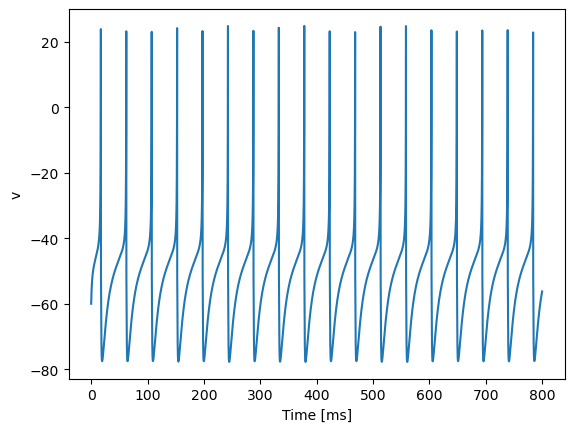

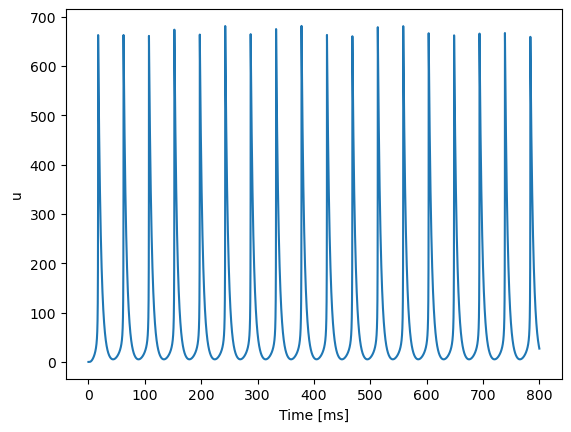

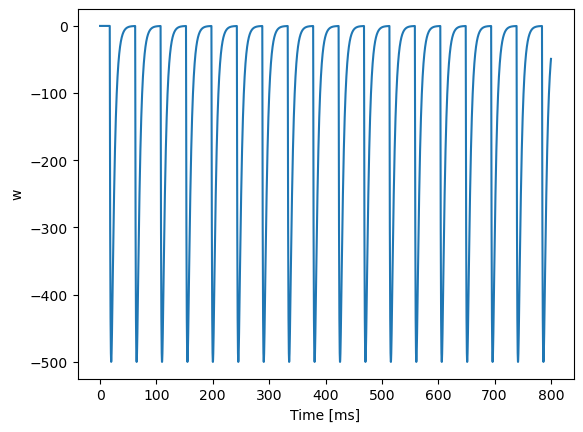

Spike times: [ 17.16  62.25 107.34 152.43 197.55 242.65 287.79 332.89 378.02 423.16
 468.25 513.34 558.48 603.62 648.72 693.81 738.91 784.01] ms


In [3]:
"""
Single FS neurons with biexponential autapse.

"""

start_scope()

FS = {'name': 'FS', 'C': 20, 'k': 1, 'v_r': -55, 'v_t': -40, 'v_peak': 25,
     'a': 0.2, 'b': -2, 'c': -45, 'd': 150, 't_a1': 1.5, 't_a2': 5, 'f': -500., 'tau': 0.0}    # Class 1

C = FS['C']
k = FS['k']
v_r = FS['v_r']
v_t = FS['v_t']
a = FS['a']
b = FS['b']
c = FS['c']
d = FS['d']
v_peak = FS['v_peak']
# autapse
# rise and decay times
t_a1 = FS['t_a1']
t_a2 = FS['t_a2']
f = FS['f']
tau = FS['tau']*ms

## The autapse could be implemented through a time-delayed synapse, or somehow the reset can be delayed manually...
eqs = f'''
dv/dt = ((1/C)*(k *(v-v_r)*(v-v_t) - u + w + I))/ms : 1
du/dt = a*(int(v>=-55)*(0.025*(v+55)**3) - u)/ms : 1
dw/dt = ((t_a2 / t_a1) ** (t_a1 / (t_a2 - t_a1))*x-w)/t_a1/ms : 1
dx/dt = -x/t_a2/ms : 1
C : 1
k : 1
v_r : 1
v_t : 1
I : 1
a : 1
b : 1
c : 1
d : 1
f : 1
t_a1 : 1
t_a2 : 1
tau : 1
'''


reset = '''
v = c
u += d
'''

G = NeuronGroup(1, eqs, threshold= 'v>=v_peak', reset = reset, method = 'rk2')

defaultclock.dt = 0.01*ms
M_v = StateMonitor(G, 'v', record = 0)
M_u = StateMonitor(G, 'u', record = 0)
M_w = StateMonitor(G, 'w', record = 0)
spikemon = SpikeMonitor(G, record = True)

# Synapses
# biexponential synapse
autapse = '''
dw/dt = ((t_a2 / t_a1) ** (t_a1 / (t_a2 - t_a1))*x-w)/t_a1/ms : 1
dx/dt = -x/t_a2/ms : 1
f : 1
t_a1 : 1
t_a2 : 1
tau : 1
'''
aut = Synapses(G, G,  
             on_pre='''
             x += f
             ''')
aut.connect(condition = 'i == j')
aut.delay = tau


# Initialise variables
G.v = -60
G.C = C
G.k = k
G.v_r = v_r
G.v_t = v_t
G.a = a
G.b = b
G.I = 75        # the driving current is static in this case
G.c = c
G.d = d
G.t_a1 = t_a1
G.t_a2 = t_a2
G.f = f


duration = 800*ms
run(duration)


plot(M_v.t/ms, M_v.v[0])
xlabel('Time [ms]')
ylabel('v')
#plt.savefig("complex_bursts.png")
show()

plot(M_u.t/ms, M_u.u[0])
xlabel('Time [ms]')
ylabel('u')
show()

plot(M_w.t/ms, M_w.w[0])
xlabel('Time [ms]')
ylabel('w')
show()

print(f"Spike times: {spikemon.t[:]}")

In [4]:
"""
Test of a biexponential autapse on FS neurons.

See if the effect on the AHP can match experimental findings a bit better.

Rise time = 1.5 ms

decay time = ~4ms

peak = 450 +- 40 pA

"""


N_neurons = 10

T = 100 # ms
dt = 0.01
N_iter = int(T/dt)

FS = {'name': 'FS', 'C': 20, 'k': 1, 'v_r': -55, 'v_t': -40, 'v_peak': 25,
     'a': 0.2, 'b': -2, 'c': -45, 'd': 150, 'e': 0.2, 'f': 0., 'tau': 0.0}    # Class 1

t_a1 = 1.5 # ms
t_a2 = 7 # ms

f_range = np.linspace(0, -500, N_neurons)

I_h = 75
I_inj = I_h*np.ones((N_neurons, N_iter))

params = []
x_start = np.zeros((N_neurons, 3))
x_ini = np.array([-60., 0., 0.])
t_start = np.zeros(N_neurons)

for i in range(N_neurons):
    params.append(FS)
    x_start[i] = x_ini

param_df = pd.DataFrame(params)

# change autapse strengths for all neurons
param_df['f'] = f_range

# instantiate batch
batch = batchAQUA(param_df)
batch.Initialise(x_start, t_start)

# convert batch to brian parameters with a biexponential autapse.
BIEXP = False
G, autapses = batch.meetBrian(BIEXP, t_a1, t_a2)

G.I = I_inj[:, 0]

# simulation timestep
defaultclock.dt = dt*ms
Mon = StateMonitor(G, ['u', 'v', 'w'], record = True)
spikemon = SpikeMonitor(G, record = True)
net = Network(G, autapses, Mon , spikemon)

# run sim
net.run(T*ms)



DECAYS: 1.5 and 7
0.6569670757257949
ALL FS!!!
 - - - - Equations - - - - 
du/dt = a*(int(v>=-55)*(0.025*(v+55)**3) - u)/ms : 1
dv/dt = ((1/C)*(k *(v-v_r)*(v-v_t) - u + w + I))/ms : 1
dw/dt = (-e_a*w)/ms : 1
C : 1
I : 1
a : 1
b : 1
c : 1
d : 1
e_a : 1
f : 1
k : 1
v_peak : 1
v_r : 1
v_t : 1


WARNING    'C' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 20. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'a' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 0.2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'k' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v_r' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value -55. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v_t' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value -40. The internal variable

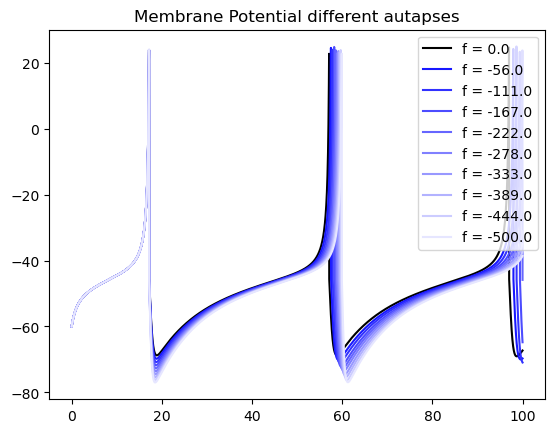

In [5]:
cmap = plt.get_cmap('bwr')
colors = cmap(np.linspace(0., 0.45, N_neurons))

time = np.arange(0, T, dt)

for i in range(N_neurons):
    if i == 0:
        col = 'black'
    else:
        col = colors[i]
    plt.plot(time, Mon.v[i], label = f"f = {np.round(f_range[i])}", color = col)

plt.legend()
plt.title("Membrane Potential different autapses")
plt.show()

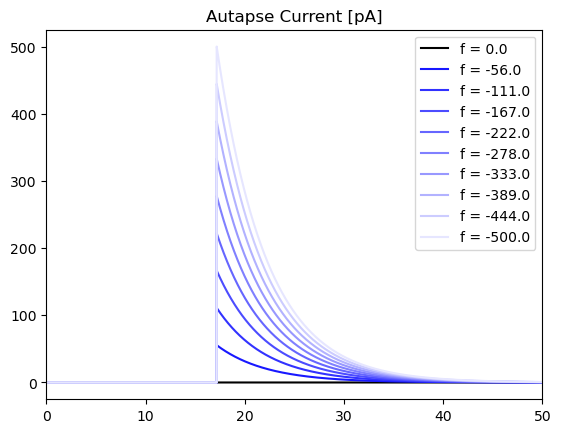

In [6]:

for i in range(N_neurons):
    if i == 0:
        col = 'black'
    else:
        col = colors[i]
    plt.plot(time, -1*Mon.w[i], label = f"f = {np.round(f_range[i])}", color = col)

plt.legend()
plt.xlim(0, 50)
plt.title("Autapse Current [pA]")
plt.show()